In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
# Define paths to the dataset
train_csv_path = r'C:/Users/Hp/Desktop/Human Action Recognition/training_set.csv'
test_csv_path = r'C:/Users/Hp/Desktop/Human Action Recognition/testing_set.csv'
train_images_path = r'C:/Users/Hp/Desktop/Human Action Recognition/train'
test_images_path = r'C:/Users/Hp/Desktop/Human Action Recognition/test'

In [3]:
# Read CSV files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

In [4]:
# Check the columns in the DataFrame
print("Training DataFrame Columns:", train_df.columns)
print("Testing DataFrame Columns:", test_df.columns)

Training DataFrame Columns: Index(['filename', 'label'], dtype='object')
Testing DataFrame Columns: Index(['filename'], dtype='object')


In [5]:
# Encode labels for training data only
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['label'])

In [6]:
# Create a test DataFrame for consistency, but without labels
test_df['label'] = np.nan  # Just to maintain structure, if needed

In [7]:
# Define a custom dataset class
class HARDSataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0])  # filename column
        image = Image.open(img_name).convert('RGB')
        label = self.dataframe.iloc[idx, 1]  # label column
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)  # Convert label to tensor if present

In [8]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [9]:

# Create datasets and dataloaders
train_dataset = HARDSataset(train_df, train_images_path, transform=transform)
test_dataset = HARDSataset(test_df, test_images_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
# Define the CNN model (no changes here)
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [11]:
# Get the number of classes
num_classes = len(train_df['label'].unique())

# Create the model, loss function, and optimizer
model = CNNModel(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
# Train the model
num_epochs = 2
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

Epoch [1/2], Loss: 2.5053, Accuracy: 0.1648
Epoch [2/2], Loss: 2.2562, Accuracy: 0.2602


In [19]:
# Evaluate the model if labels are available
if test_df['label'].notnull().all():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
           # images, labels = images.to(device), labels.to(device)  # Ensure images and labels are moved to the same device as the model
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = correct / total
    print(f'Test Accuracy: {test_accuracy:.4f}')
else:
    print("Test labels are not available. Skipping evaluation.")

Test labels are not available. Skipping evaluation.


In [18]:
# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')

# Save the model
torch.save(model.state_dict(), 'har_cnn_model.pth')


RuntimeError: value cannot be converted to type int64 without overflow

In [20]:
torch.save(model.state_dict(), 'har_cnn_model.pth')

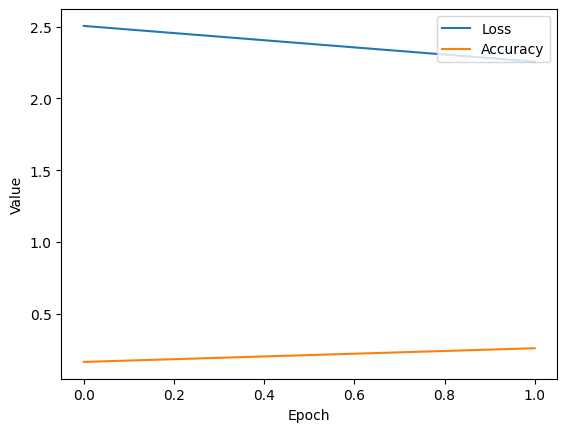

In [21]:
# Plot training history
plt.plot(train_losses, label='Loss')
plt.plot(train_accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(loc='upper right')
plt.show()